In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

## XYZ -> RGB matrix inference

In [2]:
m709 = np.mat([[0.64, 0.33, 0.03],
                [0.3, 0.6, 0.1],
                [0.15, 0.06, 0.79]])

xr, yr, zr = np.squeeze(np.array(m709[0]))
xg, yg, zg = np.squeeze(np.array(m709[1]))
xb, yb, zb = np.squeeze(np.array(m709[2]))
xw, yw, zw = 0.3127, 0.3291, 0.3582

#xyz -> rgb matrix, before scaling to white.
rx, ry, rz = (yg * zb) - (yb * zg), (xb * zg) - (xg * zb), (xg * yb) - (xb * yg)
gx, gy, gz = (yb * zr) - (yr * zb), (xr * zb) - (xb * zr), (xb * yr) - (xr * yb)
bx, by, bz = (yr * zg) - (yg * zr), (xg * zr) - (xr * zg), (xr * yg) - (xg * yr)

#White scaling factors.
#Dividing by yw scales the white luminance to unity, as conventional.
rw = ((rx * xw) + (ry * yw) + (rz * zw)) / yw
gw = ((gx * xw) + (gy * yw) + (gz * zw)) / yw
bw = ((bx * xw) + (by * yw) + (bz * zw)) / yw

#xyz -> rgb matrix, correctly scaled to white.
rx = rx / rw;  ry = ry / rw;  rz = rz / rw;
gx = gx / gw;  gy = gy / gw;  gz = gz / gw;
bx = bx / bw;  by = by / bw;  bz = bz / bw;

test_mat = np.mat([[rx, ry, rz],
                    [gx, gy, gz],
                    [bx, by, bz]])

print (test_mat)

[[ 3.24297897 -1.53833618 -0.49891984]
 [-0.96899795  1.87549198  0.04154452]
 [ 0.05566832 -0.20411719  1.05769816]]


## Simple Analytic Approximations to the CIE XYZ Color Matching Functions
by Chris Wyman, Peter-Pike Sloan, Peter Shirley

In [3]:
def ts(wl, alpha, beta, gamma, delta):
    c = wl - beta
    return alpha * np.exp(-0.5 * (c * (np.where(c < 0, gamma, delta)))**2)

def fit(wl, *args):
    return np.sum([ts(wl, *coeffs) for coeffs in args])

def multi_lobe_fit(wl):
    x_coeffs = ((0.362, 442.0, 0.0624, 0.0374),
                (1.056, 599.8, 0.0264, 0.0323),
                (-0.065, 501.1, 0.0490, 0.0382))

    y_coeffs = ((0.821, 568.8, 0.0213, 0.0247),
                (0.286, 530.9, 0.0613, 0.0322))

    z_coeffs = ((1.217, 437.0, 0.0845, 0.0278),
                (0.681, 459.0, 0.0385, 0.0725))

    return np.array([fit(wl, *x_coeffs), fit(wl, *y_coeffs), fit(wl, *z_coeffs)])

def single_lobe_cie1964(wl):
    x = 0.398 * np.exp(-1250 * np.log((wl + 570.1)/1014)**2) + 1.132 * np.exp(-234 * np.log((1338 - wl)/743.5)**2)
    y = 1.011 * np.exp(-0.5 * ((wl - 556.1)/46.14)**2)
    z = 2.060 * np.exp(-32 * np.log((wl-265.8)/180.4)**2)
    return np.array([x, y, z])

def xyz2chr(xyz):
    """XYZ to chromaticity coordinates"""
    return xyz / np.sum(xyz)

## Wavelength -> RGB conversion

In [4]:
RGB_M = np.array([[1.7552599, -0.4836786, -0.2530000],
                [-0.5441336,  1.5068789,  0.0215528],
                [0.0063467, -0.0175761,  1.2256959]])


sRGB_M = np.array([[3.2404542, -1.5371385, -0.4985314],
                 [-0.9692660,  1.8760108,  0.0415560],
                 [0.0556434, -0.2040259,  1.0572252]])

ACES = np.array([[1.0498110175, 0.0, -0.0000974845],
              [-0.4959030231, 1.3733130458, 0.0982400361],
              [0.0, 0.0, 0.9912520182]])

mms = (
    ("RGB", RGB_M),
    ("sRGB", sRGB_M),
    ("ACES", ACES),
)

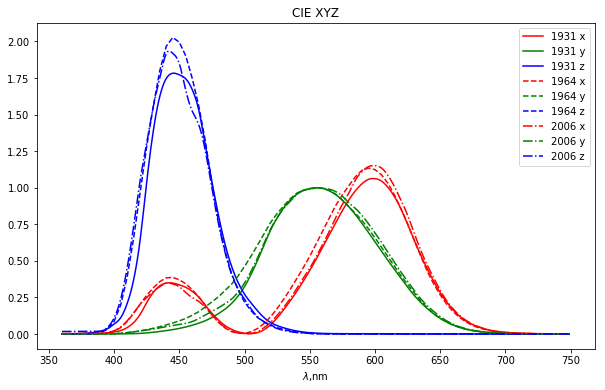

In [5]:
cie_xyz_1931 = np.insert(np.genfromtxt("CIE_XYZ_1931.csv").T, 0, np.array([0.,0.,0.,0.]), axis=1)
cie_xyz_1964 = np.insert(np.genfromtxt("CIE_XYZ_1964.csv").T, 0, np.array([0.,0.,0.,0.]), axis=1)
cie_xyz_2006 = np.insert(np.genfromtxt("lin2012xyz2e_1_7sf.csv", delimiter=',').T, 0, np.array([0.,0.,0.,0.]), axis=1)

from scipy.interpolate import interp1d

cie1931_spl = interp1d(cie_xyz_1931[0], cie_xyz_1931[1:])
cie1964_spl = interp1d(cie_xyz_1964[0], cie_xyz_1964[1:])
cie2006_spl = interp1d(cie_xyz_2006[0], cie_xyz_2006[1:])

figcie = plt.figure(figsize=(10, 6))
ax = figcie.add_subplot(111, title="CIE XYZ", xlabel="$\lambda$,nm")
spectre = np.arange(360, 750)
powers1931 = cie1931_spl(spectre)
pl = ax.plot(spectre, powers1931[0,...], "r", label="1931 x")
pl = ax.plot(spectre, powers1931[1,...], "g", label="1931 y")
pl = ax.plot(spectre, powers1931[2,...], "b", label="1931 z")
powers1964 = cie1964_spl(spectre)
pl = ax.plot(spectre, powers1964[0,...], "r--", label="1964 x")
pl = ax.plot(spectre, powers1964[1,...], "g--", label="1964 y")
pl = ax.plot(spectre, powers1964[2,...], "b--", label="1964 z")
powers2006 = cie2006_spl(spectre)
pl = ax.plot(spectre, powers2006[0,...], "r-.", label="2006 x")
pl = ax.plot(spectre, powers2006[1,...], "g-.", label="2006 y")
pl = ax.plot(spectre, powers2006[2,...], "b-.", label="2006 z")
lg = ax.legend()

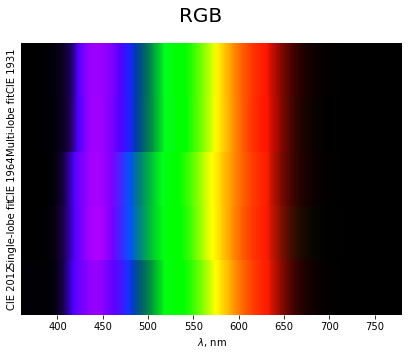

In [6]:
def wl2rgb(wl2xyz, m, wl):
    return np.squeeze(np.array(wl2xyz(wl).dot(m)))

def transform_spectre(func, spectre):
    line = np.clip(np.array([func(wl) for wl in spectre]), 0, 1)
    white = np.mean(line, 0)
    return np.repeat(np.array([line]), 60, axis=0)

def draw_spectres(mms, title, spectre_range = (360, 780), **kwargs):
    spectre = np.arange(*spectre_range)
    nrows = len(mms)
    fig, axs = plt.subplots(nrows, 1, sharex=True, figsize=(12, nrows), **kwargs)
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(hspace=0)
    for idx, (matname, func) in enumerate(mms):
        clr = transform_spectre(func, spectre)
        axs[idx].imshow(clr, extent=spectre_range+(60, 0))
        axs[idx].set_ylabel(matname)
        axs[idx].set_xlim(spectre_range)
        axs[idx].set_ylim(0, clr.shape[0])
        axs[idx].set_yticks([])
        axs[idx].set_frame_on(False)
        if idx == nrows - 1:
            axs[idx].set_xlabel("$\lambda$, nm")

mfs = (
    ("CIE 1931", cie1931_spl),
    ("Multi-lobe fit", multi_lobe_fit),
    ("CIE 1964", cie1964_spl),
    ("Single-lobe fit", single_lobe_cie1964),
    ("CIE 2012", cie2006_spl),
)

draw_spectres([(name, (lambda xyz, m: lambda wl: wl2rgb(xyz, m, wl))(mf, RGB_M)) for name, mf in mfs], "RGB")

### Black Body spectrum
$$
B_\lambda(\lambda, T) = \frac{2hc^2}{\lambda^5} \frac{1}{\exp{\frac{hc}{\lambda k_B T}} - 1}
$$

$k_B = 1.38064852 \times 10^{-23} J\cdot K^{-1}$ - Bolzmann constant

$h = 6.62607015 \times 10^{-34} J\cdot m$ - Plank constant

$c = 299792458 m$ - speed of light in vacuum

In [7]:
hc2 = 2 * 6.62607015e-34 * 299792458**2
hckb = 6.62607015e-34 * 299792458 / 1.38064852e-23

print("2hc^2 = {}\nhc/kB = {}".format(hc2, hckb))
print("c1 / c2 = {}".format(hckb / hc2))

2hc^2 = 1.1910429724e-16
hc/kB = 0.0143877737771
c1 / c2 = 1.20799787334e+14


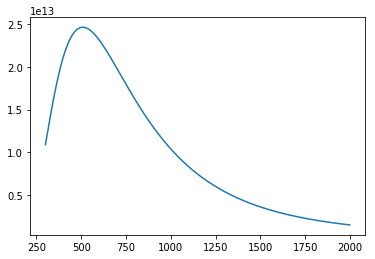

In [8]:
def black_body_walker_m(T, wvl):
    wl = wvl * 1e-9
    return (3.74183e-16 * 1 / (wl**5)) / (np.exp(1.4388e-2 / (wl * T)) - 1)

def plank_radiation(T, wvl):
    wl = wvl * 1e-9
    return 1.1910429724e-16 / (wl**5 * (np.exp(0.0143877737771 / (wl * T)) - 1))

T = 5700
spectre = np.arange(300., 2000.)
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.plot(spectre, black_body_walker_m(T, spectre), label='Walker')
ax.plot(spectre, plank_radiation(T, spectre))

/usr/lib64/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in log1p
/usr/lib64/python2.7/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


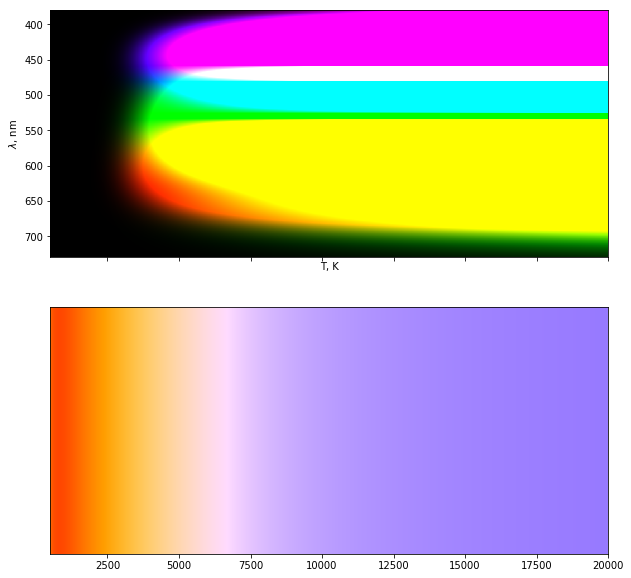

In [9]:
spectre_range = (380, 730)
temp_range = (500, 20000)

spectre = np.linspace(*(spectre_range + (600,)))
temperatures = np.linspace(*(temp_range + (1000,)))

# s1, t1 = np.meshgrid(spectre, temperatures)

# print s1.shape, t1.shape

def black_body_spectrum(wl, T):
     return single_lobe_cie1964(wl) * plank_radiation(T, wl)

vals = black_body_spectrum(*np.meshgrid(spectre, temperatures))

vals = np.swapaxes(vals, 0, 2)
integral = np.mean(vals, axis=0)
hdr = vals.dot(RGB_M)
integral_rgb = integral.dot(RGB_M)
# nrmi = np.clip(np.log1p(integral_rgb / np.sum(integral_rgb) * 1e4), 0, 1) # integral_rgb / np.repeat(np.max(integral_rgb, axis=1)[...,np.newaxis], 3, axis=1)
nrmi = integral_rgb / np.repeat(np.max(integral_rgb, axis=1)[...,np.newaxis], 3, axis=1)
nrmi = np.repeat(nrmi[None,...], 60, axis=0)

clr = np.clip(np.log1p(hdr / np.sum(hdr) * 1e8), 0, 1)
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10,10))
axs[0].set_xlabel("T, K")
axs[0].set_ylabel("$\lambda$, nm")
im1 = axs[0].imshow(clr, extent=temp_range + spectre_range[::-1], aspect='auto')
axs[1].set_yticks([])
im2 = axs[1].imshow(nrmi, extent=temp_range + spectre_range[::-1], aspect='auto')
# print vals.shape

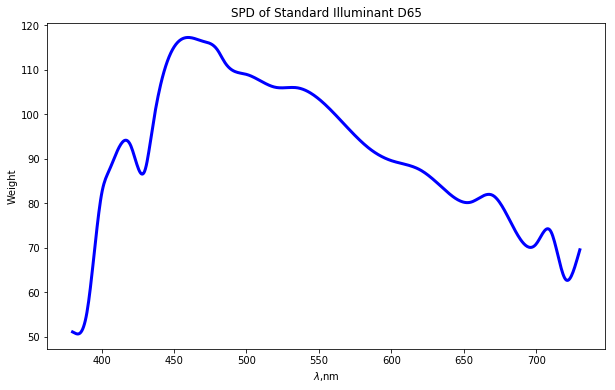

In [10]:
cie_d65_data = np.genfromtxt("CIE_D65.csv", skip_header=5)

# wavelength and weights
wvls = cie_d65_data.T[0]
weigths = cie_d65_data.T[1]


from scipy.interpolate import UnivariateSpline

spl = UnivariateSpline(wvls, weigths)

figd65 = plt.figure(figsize=(10, 6))
ax = figd65.add_subplot(111, title="SPD of Standard Illuminant D65", ylabel="Weight", xlabel="$\lambda$,nm")
pl = ax.plot(spectre, spl(spectre), "b", lw=3)